Enter the coefficient for x in the objective function: -3
Enter the coefficient for y in the objective function: -2
Enter the number of constraints: 5
Enter the coefficient for x in the constraint: 2
Enter the coefficient for y in the constraint: 1
Enter the inequality sign (<= or >=): <=
Enter the right-hand side value: 8
Enter the coefficient for x in the constraint: -1
Enter the coefficient for y in the constraint: 1
Enter the inequality sign (<= or >=): <=
Enter the right-hand side value: 1
Enter the coefficient for x in the constraint: 0
Enter the coefficient for y in the constraint: 1
Enter the inequality sign (<= or >=): <=
Enter the right-hand side value: 2
Enter the coefficient for x in the constraint: 1
Enter the coefficient for y in the constraint: 0
Enter the inequality sign (<= or >=): >=
Enter the right-hand side value: 0
Enter the coefficient for x in the constraint: 0
Enter the coefficient for y in the constraint: 1
Enter the inequality sign (<= or >=): >=
Enter the rig

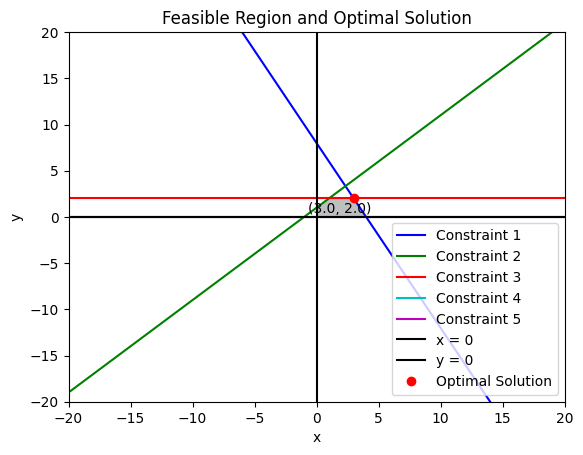

In [4]:
from sympy import symbols, Eq, solve, N
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from scipy.spatial import ConvexHull
import warnings
warnings.filterwarnings("ignore")
# Define the variables
x, y = symbols('x y')

# Function to get user input for the objective function
def get_objective_function():
    obj_x = float(input("Enter the coefficient for x in the objective function: "))
    obj_y = float(input("Enter the coefficient for y in the objective function: "))
    return obj_x, obj_y

# Function to get user input for constraints
def get_constraints():
    constraints = []
    num_constraints = int(input("Enter the number of constraints: "))
    for _ in range(num_constraints):
        coeff_x = float(input("Enter the coefficient for x in the constraint: "))
        coeff_y = float(input("Enter the coefficient for y in the constraint: "))
        sign = input("Enter the inequality sign (<= or >=): ")
        rhs = float(input("Enter the right-hand side value: "))
        if sign == "<=":
            constraints.append((coeff_x, coeff_y, rhs, "<="))
        elif sign == ">=":
            constraints.append((coeff_x, coeff_y, rhs, ">="))
    return constraints

# Get user input for the objective function and constraints
obj_x, obj_y = get_objective_function()
constraints = get_constraints()

# Solve the system of equations for each pair of constraints to find corner points
corner_points = []
for i in range(len(constraints)):
    for j in range(i + 1, len(constraints)):
        coeffs1 = constraints[i]
        coeffs2 = constraints[j]
        expr1 = Eq(coeffs1[0] * x + coeffs1[1] * y, coeffs1[2])
        expr2 = Eq(coeffs2[0] * x + coeffs2[1] * y, coeffs2[2])
        solution = solve((expr1, expr2), (x, y))
        if solution:
            corner_points.append((N(solution[x]), N(solution[y])))

# Filter out points that don't satisfy all constraints
feasible_points = []
for point in corner_points:
    if all(
        (coeffs[0] * point[0] + coeffs[1] * point[1] <= coeffs[2] if coeffs[3] == '<=' else coeffs[0] * point[0] + coeffs[1] * point[1] >= coeffs[2])
        for coeffs in constraints
    ):
        feasible_points.append(point)

# Define the objective function
def objective_function(x_val, y_val):
    return obj_x * x_val + obj_y * y_val

# Generate x and y values for plotting
x_vals = np.linspace(-20, 20, 1000)
y_vals = np.linspace(-20, 20, 1000)
X, Y = np.meshgrid(x_vals, y_vals)

# Plot the feasible region and constraints
plt.figure()
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'cyan', 'pink', 'darkviolet', 'lime', 'peru']
for idx, coeffs in enumerate(constraints):
    coeff_x, coeff_y, rhs, sign = coeffs
    if coeff_y != 0:
        y_line = (rhs - coeff_x * x_vals) / coeff_y
    else:
        y_line = np.full_like(x_vals, rhs / coeff_x)
    plt.plot(x_vals, y_line, label=f'Constraint {idx + 1}', color=colors[idx % len(colors)])

# Plot x = 0 and y = 0 lines
plt.axvline(x=0, color='black', label='x = 0')
plt.axhline(y=0, color='black', label='y = 0')

# Fill the feasible region
if feasible_points:
    feasible_points = np.array(feasible_points, dtype=float)
    if len(feasible_points) >= 3:
        hull = feasible_points[ConvexHull(feasible_points).vertices]
        plt.fill(hull[:, 0], hull[:, 1], 'grey', alpha=0.5)
    else:
        print('Not enough feasible points to construct the convex hull')

# Use linprog to find the optimal solution
c = [obj_x, obj_y]
A = []
b = []
for coeff_x, coeff_y, rhs, sign in constraints:
    if sign == "<=":
        A.append([coeff_x, coeff_y])
        b.append(rhs)
    elif sign == ">=":
        A.append([-coeff_x, -coeff_y])
        b.append(-rhs)

result = linprog(c, A_ub=A, b_ub=b, method='simplex') #method = 'simplex': sử dụng phương pháp đơn hình để giải bài toán quy hoạch tuyến tính
if result.success:
    optimal_point = result.x
    optimal_value = result.fun
    ask = input('Do you want to print number of iterations, optimal point and optimal value? (yes/no): ')
    if ask == 'yes':
        optimization_type = input("What type of the objective function? (max/min): ")
        if optimization_type == 'max':
            optimal_value = -optimal_value
        else:
            optimal_value = optimal_value
        print('optimal_point:', optimal_point)
        print('optimal_value:', optimal_value)
        print('Total number of iterations:', result.nit)

    # Plot the optimal solution
    plt.plot(optimal_point[0], optimal_point[1], 'ro', label='Optimal Solution')
    plt.annotate(f'({optimal_point[0]}, {optimal_point[1]})', (optimal_point[0], optimal_point[1]), textcoords="offset points", xytext=(-10,-10), ha='center')
    plt.legend(loc="lower right")
else:
    print('No feasible solution')
    plt.legend(loc="lower right")
# Set plot limits and labels
plt.xlim((-20, 20))
plt.ylim((-20, 20))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Feasible Region and Optimal Solution')

plt.show()
